# JEM207 Python Project

In [1]:
#Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Library for basic plots
import seaborn as sns #Library for advanced plots
import re
import plotly.graph_objects as go #library for radar chart
from sklearn.model_selection import train_test_split, cross_val_score, KFold #Module for k-folding
from sklearn.preprocessing import StandardScaler, OneHotEncoder #Module for preprocessing
from sklearn.compose import ColumnTransformer #Module for composing columns
from sklearn.pipeline import Pipeline #Module for generating pipelines
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #Library for linear models (LPM, Logit, and Probit)
from sklearn.ensemble import RandomForestClassifier #Library for Random Forest 
from sklearn.svm import SVC #Library for Suported Vector Machine models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Library for performance metrics
from ucimlrepo import fetch_ucirepo #Library for data

In [2]:
#Getting the data
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
features = heart_disease.data.features
targets = heart_disease.data.targets

# metadata 
print(heart_disease.metadata) 

# variable information 
print(heart_disease.variables) 

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [3]:
#Base dimensioning of the data
print(features.shape)
print(targets.shape)

(303, 13)
(303, 1)


In [4]:
#Base characteristics of the datasets
print(features.info(), "\n")
print(targets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   num     303 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB
None

## Pre-setting
Tidying of the data and unification of the datasets.

In [5]:
#Unification
base_df = pd.concat([features, targets], axis=1)
base_df = base_df.rename(columns={"num":"target"}) #For making the target easier to distinguish

#Setting of correct data types
base_df = base_df.astype({"sex": "category", "cp": "category", "fbs": "category", "restecg": "category",
               "exang": "category", "slope": "category", "thal": "category", "target": "category"})

In [6]:
#Corroborations of consistency
print("Current data types", base_df.dtypes, sep="\n", end="\n\n")
print("Dimensions of the dataset", base_df.shape, sep="\n", end="\n\n")
print("NA identification, total NAs in each attribute:", base_df.isna().sum(), sep="\n", end="\n\n")

print("NaN verification, total NaN in each attribute:")
for column in base_df.columns:
    if base_df[column].dtypes != "category":
        print(column, ":", sum(base_df[column].apply(np.isnan)))

Current data types
age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
target      category
dtype: object

Dimensions of the dataset
(303, 14)

NA identification, total NAs in each attribute:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

NaN verification, total NaN in each attribute:
age : 0
trestbps : 0
chol : 0
thalach : 0
oldpeak : 0
ca : 4


<b> Handling missing data </b>
<br>
- For numeric data we decided to imputate the mean in order to keep the consistency of the data and not loose those registers.<br>
- Fur categorical data, in order to avoid possible bias, we decided to drop the two registers that were NAs taking into account that putting an arbitrary value there could alter our analysis.

In [7]:
#Secure copy
df = base_df.copy()

In [8]:
#Imputation and dropping
df["ca"] = df["ca"].fillna(df["ca"].mean()) #Filling with the mean 
df.dropna(axis=0,how="any",inplace=True) #Dropping qualitative missing data

In [9]:
#Corroboration
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       301 non-null    int64   
 1   sex       301 non-null    category
 2   cp        301 non-null    category
 3   trestbps  301 non-null    int64   
 4   chol      301 non-null    int64   
 5   fbs       301 non-null    category
 6   restecg   301 non-null    category
 7   thalach   301 non-null    int64   
 8   exang     301 non-null    category
 9   oldpeak   301 non-null    float64 
 10  slope     301 non-null    category
 11  ca        301 non-null    float64 
 12  thal      301 non-null    category
 13  target    301 non-null    category
dtypes: category(8), float64(2), int64(4)
memory usage: 20.0 KB


## Descriptive statistics
Were executed in the standad database that covers the attributes:
<ol>
<li>age: Age of the patient</li>
<li>sex: Sex of the patient (Male, Female)</li>
<li>cp: Chest pain type (Categorical with 4 levels-Type 1, Type 2, Type 3 and Type 4) Type 1:typical angina <li>Type 2:atypical angina Type 3:non-anginal pain Type 4:asymptomatic</li>
<li>trestbps: Resting blood pressure-in mm Hg on admission to the hospital(Continuous)</li>
<li>chol: Serum cholesterol in mg/dl (Continuous)</li>
<li>fbs: Fasting blood sugar > 120 mg/dl (True,False)</li>
<li>restecg: Resting electrocardiographic results (N(Normal), L1(Level 1), L2(Level 2))</li>
<li>thalach: Maximum heart rate achieved (Continuous)</li>
<li>exang: Exercise induced angina (Yes, No)</li>
<li>oldpeak: ST depression induced by exercise relative to rest (Continuous)</li>
<li>slope: The slope of the peak exercise ST segment (Up, Flat, Down)</li>
<li>ca: Number of major vessels (0-3) colored by flourosopy (0, 1, 2, 3)</li>
<li>thal: The heart status as retrieved from Thallium test (N(normal),FD(fixed defect), RD(reversible defect)</li>
</ol>

In [10]:
#Pre-view
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


In [11]:
#Summary statistics of numerical data
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.451827,131.714286,246.936877,149.700997,1.043189,0.676708
std,9.067258,17.655729,51.859869,22.860817,1.163384,0.932684
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,134.000000,0.000000,0.000000
50%,56.000000,130.000000,242.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


In [12]:
#Summary statistics of categorical data
df.describe(include='category')

,sex,cp,fbs,restecg,exang,slope,thal,target
count,301,301,301,301,301,301,301.0,301
unique,2,4,2,3,2,3,3.0,5
top,1,4,0,0,0,1,3.0,0
freq,205,143,257,150,203,141,166.0,163


In [13]:
#Changing the base style of the graphs
sns.set(style="whitegrid") #Similar to ggplot 2

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'ca'}>]], dtype=object)

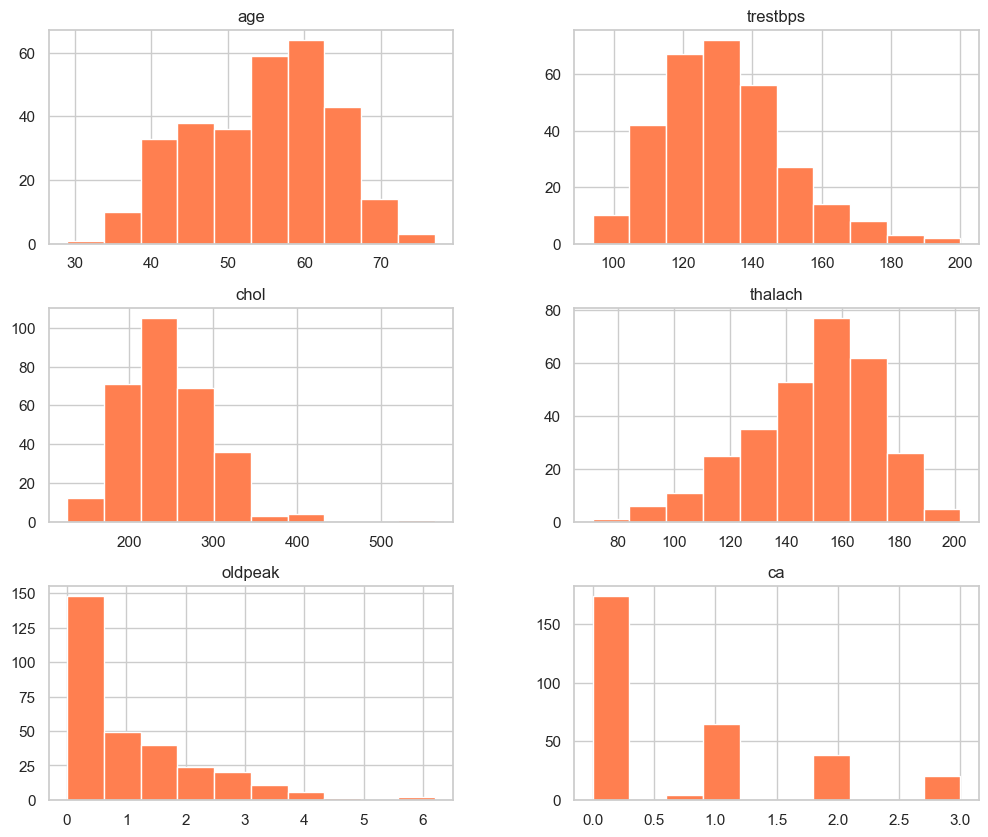

In [14]:
#Histograms for numeric data
plt.rcParams["figure.figsize"] = (12, 10) #Resizing the plot
df[df.columns].hist(color="coral")

<b>Testing variability across groups</b>
- Sex: To understand if men and women have different fistribution across the studied attributes.
- Age: Based on the findings that "Adults age 65 and older are more likely than younger people to suffer from cardiovascular disease" (National institute of Angin, 2018), we want to test if there is a difference in the dataset for people under and over the threshold (including the frontier). 

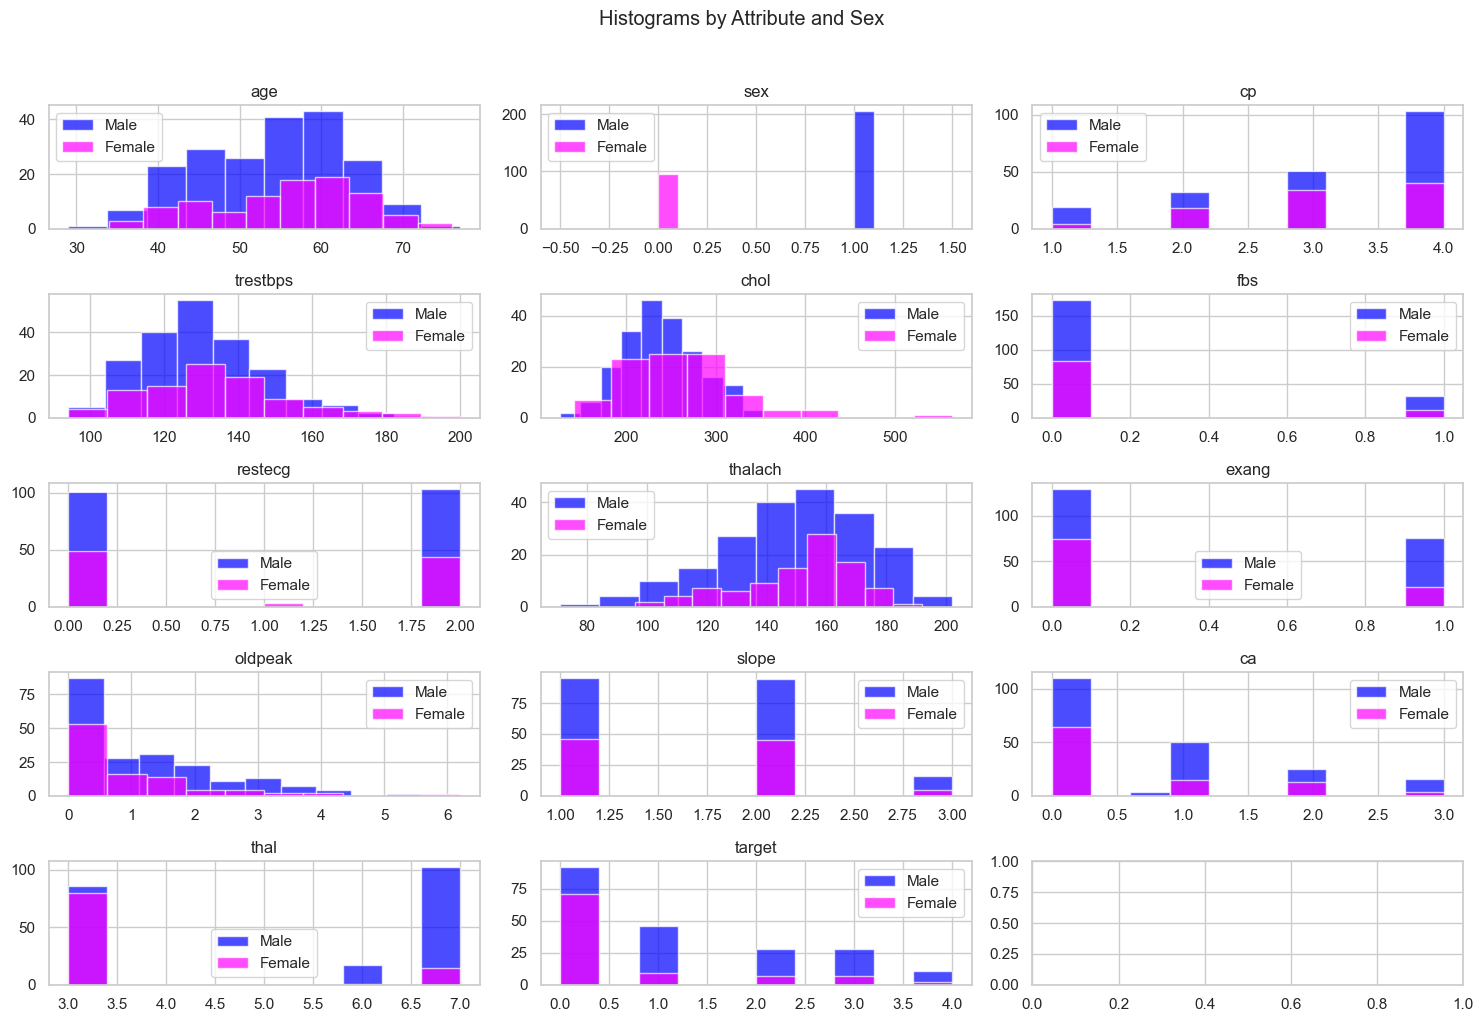

In [15]:
#Robustness check for sex:
#Separation of the data by sex
male_data = df[df['sex'] == 1]
female_data = df[df['sex'] == 0]

#Create subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
fig.suptitle('Histograms by Attribute and Sex', y=1.02)

#Flatten the axes array if it's not 2D
axes = axes.flatten() if len(df.columns) > 1 else [axes]

# Plot histograms for each attribute in each subplot
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    ax.hist(male_data[col], alpha=0.7, label='Male', color='blue', bins=10)
    ax.hist(female_data[col], alpha=0.7, label='Female', color='magenta', bins=10)
    ax.set_title(col)
    ax.legend()

#Adjust layout for better spacing
plt.tight_layout()

#Deploy
plt.show()

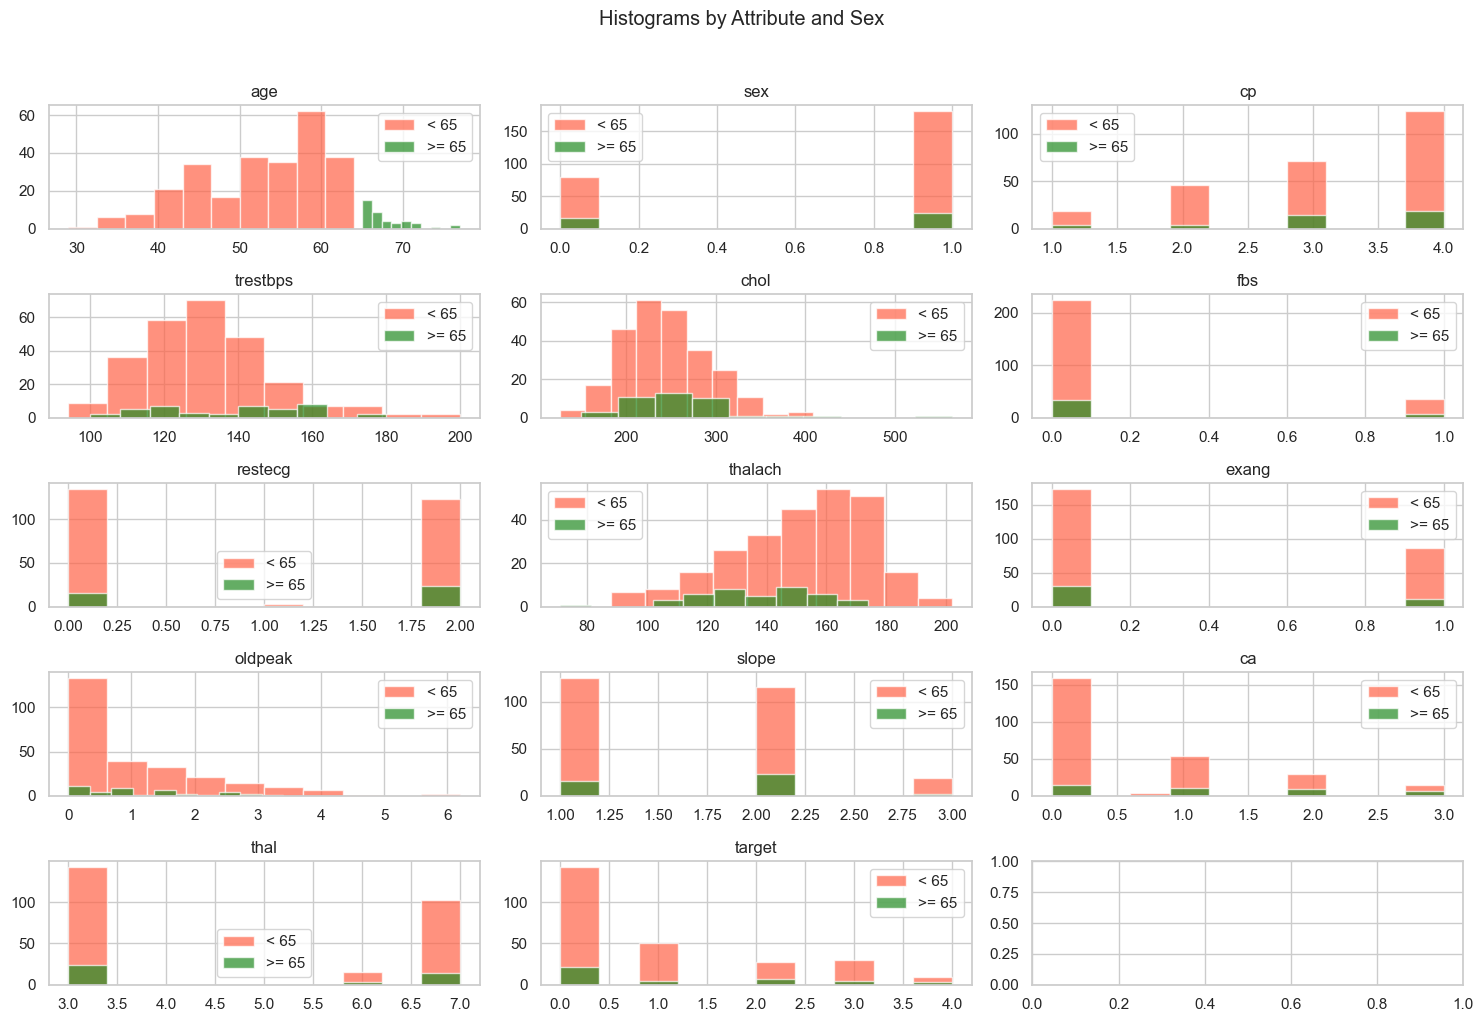

In [16]:
#Robustness check for age groups:

#Separation of the data by people under and in the threshold
under65_data = df[df['age'] < 65]
plus65_data = df[df['age'] >= 65]

#Create subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
fig.suptitle('Histograms by Attribute and Sex', y=1.02)

#Flatten the axes array if it's not 2D
axes = axes.flatten() if len(df.columns) > 1 else [axes]

# Plot histograms for each attribute in each subplot
for i, (col, ax) in enumerate(zip(df.columns, axes)):
    ax.hist(under65_data[col], alpha=0.7, label='< 65', color='tomato', bins=10)
    ax.hist(plus65_data[col], alpha=0.7, label='>= 65', color='forestgreen', bins=10)
    ax.set_title(col)
    ax.legend()

#Adjust layout for better spacing
plt.tight_layout()

#Deploy
plt.show()

<Axes: >

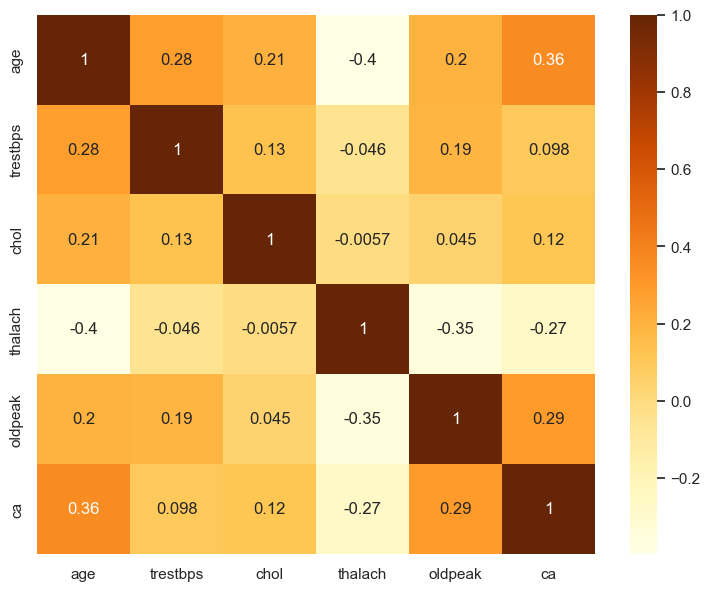

In [17]:
#Correlation between variables
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlOrBr")

## K-folding
For the exercise, and taking into account the size of the dataset, we decided to use the empirical approach of 80% of the data going for training and 20% for testing. Saving enough observations for runing the basic models.

In [18]:
#Spliting between target and explanatory variables
X = df.loc[:, df.columns[df.columns != "target"]] #Attributes
Y = df["target"]

#Spliting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

In [19]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
290,67,1,3,152,212,0,2,150,0,0.8,2,0.0,7.0
52,44,1,4,112,290,0,2,153,0,0.0,1,1.0,3.0
171,53,1,4,142,226,0,2,111,1,0.0,1,0.0,7.0
207,50,1,4,144,200,0,2,126,1,0.9,2,0.0,7.0
143,64,1,3,125,309,0,0,131,1,1.8,2,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,67,1,4,120,237,0,0,71,0,1.0,2,0.0,3.0
231,55,0,4,180,327,0,1,117,1,3.4,2,0.0,3.0
16,48,1,2,110,229,0,0,168,0,1.0,3,0.0,7.0
74,44,1,4,110,197,0,2,177,0,0.0,1,1.0,3.0


## Models

In [20]:
##Pre-processing 
#Creating preprocessing workflow for one hot encoding and standardization.

#Separate numerical and categorical features for parallel treatments.
numeric_features = df.columns[df.dtypes == "int64"]
categorical_features = df.columns[(df.dtypes == "category") & (df.columns != "target")] #Target is excluded from one-hot encoding

#Preprocessing and scalation
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())]) #Standardizing numeric fields.
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())]) #One-hot encoding for categorical data

#Combine transformers
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

##Cross Validation
folds = KFold(n_splits=5, shuffle=True, random_state=13)

- <b>LINEAR DISCRIMINANT ANALYSIS</b>

In [21]:
#Create a pipeline with preprocessing and logistic regression
ldm_model = Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier', LinearDiscriminantAnalysis())])

#Fit the model
ldm_model.fit(X_train, Y_train)

#Testing the model  via cross validation
cv_scores = cross_val_score(ldm_model, X_train, Y_train, cv=folds, scoring='accuracy')

#Make predictions on the scaled testing set
Y_pred = ldm_model.predict(X_test)

#Cross-validation performance
print(f"Cross-Validation mean score: {np.mean(cv_scores)}")
print(f"Cross-Validation standard deviation: {np.std(cv_scores)}")

#Evaluate the accuracy
accuracy_scaled = accuracy_score(Y_test, Y_pred)
print(f"Accuracy with scaling: {accuracy_scaled:.2f}")

#Display classification report
print("Classification Report")
print(classification_report(Y_test, Y_pred))

Cross-Validation mean score: 0.5333333333333333
Cross-Validation standard deviation: 0.07637626158259735
Accuracy with scaling: 0.61
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        39
           1       0.25      0.40      0.31         5
           2       0.12      0.14      0.13         7
           3       0.33      0.33      0.33         9
           4       0.00      0.00      0.00         1

    accuracy                           0.61        61
   macro avg       0.32      0.33      0.32        61
weighted avg       0.65      0.61      0.63        61



- <b>LOGISTIC REGRESSION </b>

In [22]:
#Create a pipeline with preprocessing and logistic regression
log_model = Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier', LogisticRegression())])

#Fit the model
log_model.fit(X_train, Y_train)

#Testing the model  via cross validation
cv_scores = cross_val_score(log_model, X_train, Y_train, cv=folds, scoring='accuracy')

#Make predictions on the scaled testing set
Y_pred = log_model.predict(X_test)

#Cross-validation performance
print(f"Cross-Validation mean score: {np.mean(cv_scores)}")
print(f"Cross-Validation standard deviation: {np.std(cv_scores)}")

#Evaluate the accuracy
accuracy_scaled = accuracy_score(Y_test, Y_pred)
print(f"Accuracy with scaling: {accuracy_scaled:.2f}")

#Display classification report
print("Classification Report")
print(classification_report(Y_test, Y_pred))

Cross-Validation mean score: 0.55
Cross-Validation standard deviation: 0.07288689868556628
Accuracy with scaling: 0.59
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        39
           1       0.20      0.40      0.27         5
           2       0.00      0.00      0.00         7
           3       0.33      0.22      0.27         9
           4       0.00      0.00      0.00         1

    accuracy                           0.59        61
   macro avg       0.28      0.29      0.28        61
weighted avg       0.63      0.59      0.61        61



- <b>PROBIT REGRESSION </b>

In [23]:
#Create a pipeline with preprocessing and logistic regression
probit_model = Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier',  LogisticRegression(solver='lbfgs', max_iter=1000, random_state=13))])

#Fit the model
probit_model.fit(X_train, Y_train)

#Testing the model  via cross validation
cv_scores = cross_val_score(probit_model, X_train, Y_train, cv=folds, scoring='accuracy')

#Make predictions on the scaled testing set
Y_pred = probit_model.predict(X_test)

#Cross-validation performance
print(f"Cross-Validation mean score: {np.mean(cv_scores)}")
print(f"Cross-Validation standard deviation: {np.std(cv_scores)}")

#Evaluate the accuracy
accuracy_scaled = accuracy_score(Y_test, Y_pred)
print(f"Accuracy with scaling: {accuracy_scaled:.2f}")

#Display classification report
print("Classification Report")
print(classification_report(Y_test, Y_pred))

Cross-Validation mean score: 0.55
Cross-Validation standard deviation: 0.07288689868556628
Accuracy with scaling: 0.59
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        39
           1       0.20      0.40      0.27         5
           2       0.00      0.00      0.00         7
           3       0.33      0.22      0.27         9
           4       0.00      0.00      0.00         1

    accuracy                           0.59        61
   macro avg       0.28      0.29      0.28        61
weighted avg       0.63      0.59      0.61        61



- <b>RANDOM FOREST </b>

In [24]:
#Create a pipeline with preprocessing and Random forest
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=13))])

#Fit the model
rf_model.fit(X_train, Y_train)

#Testing the model  via cross validation
cv_scores = cross_val_score(rf_model, X_train, Y_train, cv=folds, scoring='accuracy')

#Make predictions on the scaled testing set
Y_pred = rf_model.predict(X_test)

#Cross-validation performance
print(f"Cross-Validation mean score: {np.mean(cv_scores)}")
print(f"Cross-Validation standard deviation: {np.std(cv_scores)}")

#Evaluate the accuracy
accuracy_scaled = accuracy_score(Y_test, Y_pred)
print(f"Accuracy with scaling: {accuracy_scaled:.2f}")

#Display classification report
print("Classification Report")
print(classification_report(Y_test, Y_pred))

Cross-Validation mean score: 0.5625
Cross-Validation standard deviation: 0.07453559924999298
Accuracy with scaling: 0.62
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        39
           1       0.20      0.40      0.27         5
           2       0.33      0.43      0.38         7
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         1

    accuracy                           0.62        61
   macro avg       0.28      0.33      0.30        61
weighted avg       0.60      0.62      0.61        61



- <b>SUPPORTED VECTOR MACHINE </b>

In [25]:
#Create a pipeline with preprocessing and SVM
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(random_state=13))])

#Fit the model
svm_model.fit(X_train, Y_train)

#Testing the model  via cross validation
cv_scores = cross_val_score(svm_model, X_train, Y_train, cv=folds, scoring='accuracy')

#Make predictions on the scaled testing set
Y_pred = svm_model.predict(X_test)

#Cross-validation performance
print(f"Cross-Validation mean score: {np.mean(cv_scores)}")
print(f"Cross-Validation standard deviation: {np.std(cv_scores)}")

#Evaluate the accuracy
accuracy_scaled = accuracy_score(Y_test, Y_pred)
print(f"Accuracy with scaling: {accuracy_scaled:.2f}")

#Display classification report
print("Classification Report")
print(classification_report(Y_test, Y_pred, zero_division=0)) #Adjusted parameter due to the fact that some classes were not classified by the model

Cross-Validation mean score: 0.5250000000000001
Cross-Validation standard deviation: 0.058034951154933824
Accuracy with scaling: 0.67
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        39
           1       0.33      0.80      0.47         5
           2       0.25      0.14      0.18         7
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         1

    accuracy                           0.67        61
   macro avg       0.28      0.37      0.30        61
weighted avg       0.57      0.67      0.61        61



Cross Validation Results: 



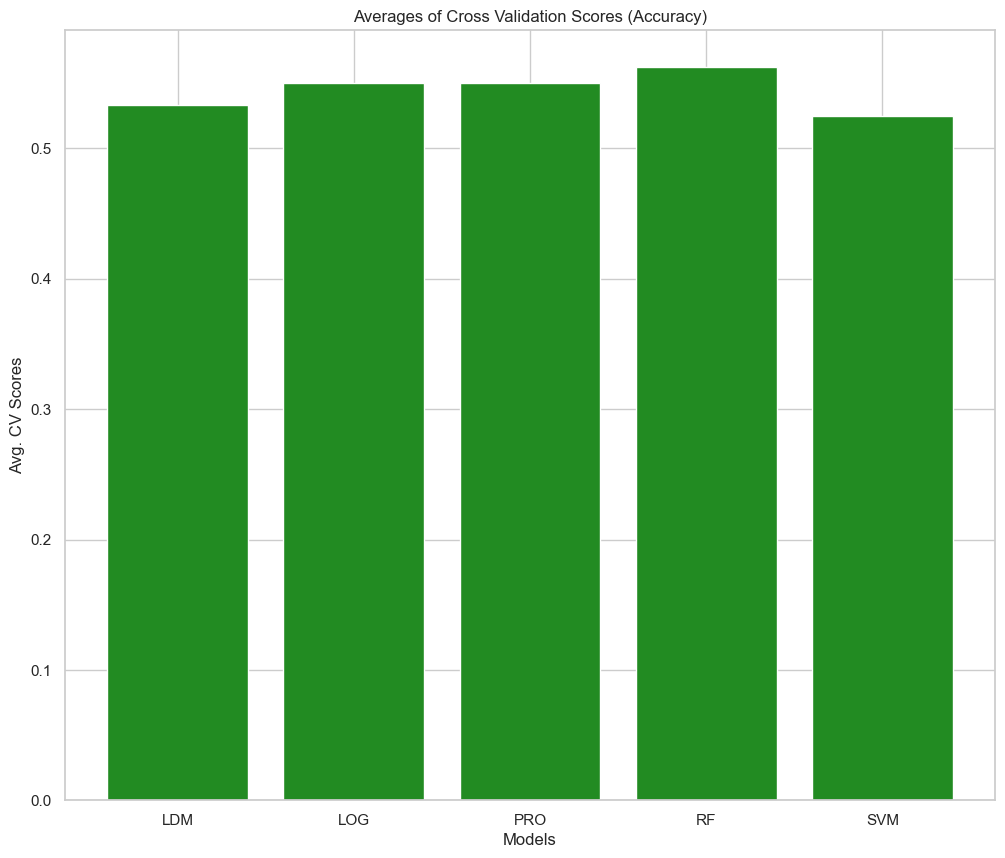

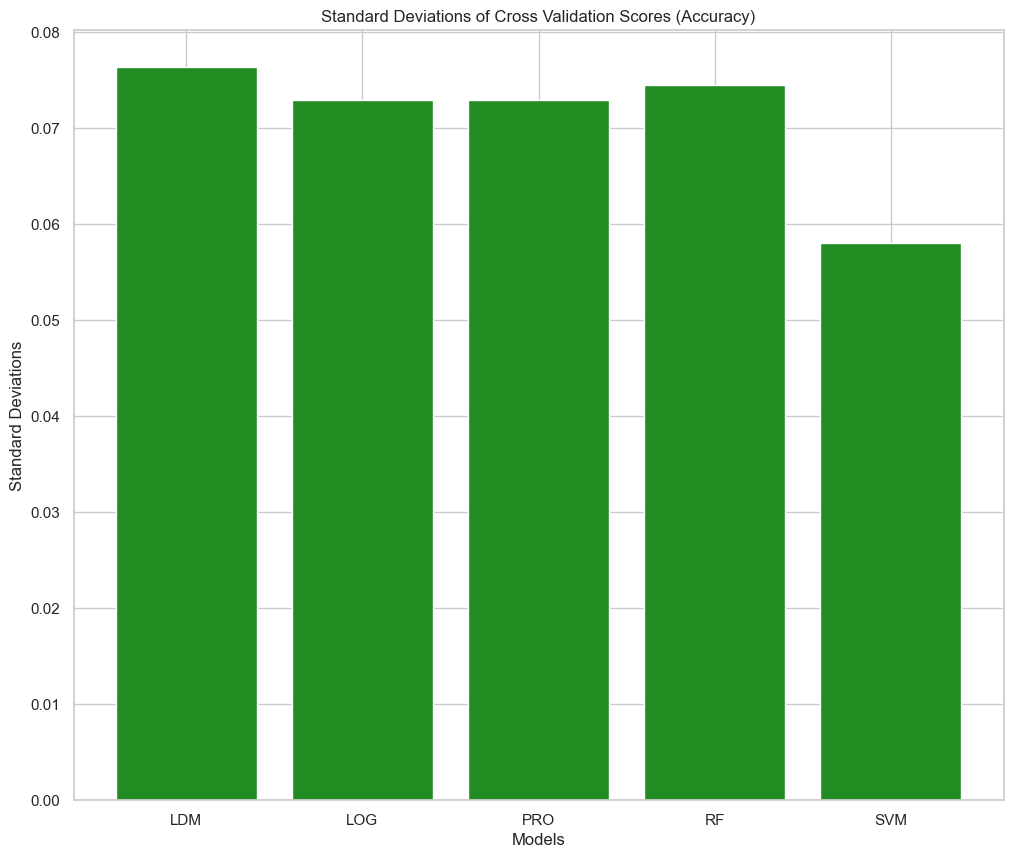

     CV Mean Score  CV Standard Deviation
LDM       0.533333               0.076376
LOG       0.550000               0.072887
PRO       0.550000               0.072887
RF        0.562500               0.074536
SVM       0.525000               0.058035 

Model Performance Analysis: 



     Accuracy  Precision  Recall  F1-Score
LDM     0.607       0.65    0.61      0.63
LOG     0.590       0.63    0.59      0.61
PRO     0.590       0.63    0.59      0.61
RF      0.623       0.60    0.62      0.61
SVM     0.672       0.57    0.67      0.61

    hello
    


In [30]:
## Function

def ModelPerformance(data, response):
    """
    hello
    """
    # Preprocessing
    X = data.loc[:, data.columns[data.columns != response]] 
    Y = data[response]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

    numeric_features = data.columns[data.dtypes == "int64"]
    categorical_features = data.columns[(data.dtypes == "category") & (data.columns != response)]
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])
    
    folds = KFold(n_splits=5, shuffle=True, random_state=13)
    
    # Linear Discriminant Model
    ldm_model = Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier', LinearDiscriminantAnalysis())])
    ldm_model.fit(X_train, Y_train)
    cv_scores_ldm = cross_val_score(ldm_model, X_train, Y_train, cv=folds, scoring='accuracy')
    Y_pred_ldm = ldm_model.predict(X_test)
    accuracy_ldm = round(accuracy_score(Y_test, Y_pred_ldm),3)
    report_ldm = classification_report(Y_test, Y_pred_ldm)
    precision_ldm = float(re.search(r'weighted avg\s+([\d.]+)', report_ldm).group(1))
    recall_ldm = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_ldm).group(2))
    f1_score_ldm = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_ldm).group(3))
    
    # Logistic Regression Model
    log_model = Pipeline(steps=[('preprocessor', preprocessor), 
                            ('classifier', LogisticRegression())])

    log_model.fit(X_train, Y_train)
    cv_scores_log = cross_val_score(log_model, X_train, Y_train, cv=folds, scoring='accuracy')
    Y_pred_log = log_model.predict(X_test)
    accuracy_log = round(accuracy_score(Y_test, Y_pred_log),3)
    report_log = classification_report(Y_test, Y_pred_log)
    precision_log = float(re.search(r'weighted avg\s+([\d.]+)', report_log).group(1))
    recall_log = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_log).group(2))
    f1_score_log = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_log).group(3))
    
    # Probit Regression Model
    probit_model = Pipeline(steps=[('preprocessor', preprocessor), 
                                ('classifier',  LogisticRegression(solver='lbfgs', max_iter=1000, random_state=13))])
    probit_model.fit(X_train, Y_train)
    cv_scores_probit = cross_val_score(probit_model, X_train, Y_train, cv=folds, scoring='accuracy')
    Y_pred_probit = probit_model.predict(X_test)
    accuracy_probit = round(accuracy_score(Y_test, Y_pred_probit),3)
    report_probit = classification_report(Y_test, Y_pred_probit)
    precision_probit = float(re.search(r'weighted avg\s+([\d.]+)', report_probit).group(1))
    recall_probit = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_probit).group(2))
    f1_score_probit = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_probit).group(3))
    
    
    # Random Forest Model
    rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(random_state=13))])
    rf_model.fit(X_train, Y_train)
    cv_scores_rf = cross_val_score(rf_model, X_train, Y_train, cv=folds, scoring='accuracy')
    Y_pred_rf = rf_model.predict(X_test)  
    accuracy_rf = round(accuracy_score(Y_test, Y_pred_rf),3)
    report_rf = classification_report(Y_test, Y_pred_rf)
    precision_rf = float(re.search(r'weighted avg\s+([\d.]+)', report_rf).group(1))
    recall_rf = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_rf).group(2))
    f1_score_rf = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_rf).group(3))
    
    # Supported Vector Machine Model
    svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(random_state=13))])
    svm_model.fit(X_train, Y_train)
    cv_scores_svm = cross_val_score(svm_model, X_train, Y_train, cv=folds, scoring='accuracy')
    Y_pred_svm = svm_model.predict(X_test)
    accuracy_svm = round(accuracy_score(Y_test, Y_pred_svm),3)
    report_svm = classification_report(Y_test, Y_pred_svm, zero_division=0)
    precision_svm = float(re.search(r'weighted avg\s+([\d.]+)', report_svm).group(1))
    recall_svm = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_svm).group(2))
    f1_score_svm = float(re.search(r'weighted avg\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', report_svm).group(3))
    
    # Cross Validation mean score and standard deviation results
    
    cv_scores = pd.DataFrame({"CV Mean Score":[np.mean(cv_scores_ldm),np.mean(cv_scores_log),np.mean(cv_scores_probit),
                                               np.mean(cv_scores_rf),np.mean(cv_scores_svm)],
                             "CV Standard Deviation":[np.std(cv_scores_ldm),np.std(cv_scores_log),np.std(cv_scores_probit),
                                                 np.std(cv_scores_rf),np.std(cv_scores_svm)]})
    cv_scores.index = ["LDM","LOG","PRO","RF","SVM"]
    
    print("Cross Validation Results: \n")
    
    plt.bar(["LDM","LOG","PRO","RF","SVM"], [np.mean(cv_scores_ldm),np.mean(cv_scores_log),np.mean(cv_scores_probit),
            np.mean(cv_scores_rf),np.mean(cv_scores_svm)], color="forestgreen")
    plt.title("Averages of Cross Validation Scores (Accuracy)")
    plt.xlabel('Models')
    plt.ylabel('Avg. CV Scores')
    plt.show()
    
    plt.bar(["LDM","LOG","PRO","RF","SVM"], [np.std(cv_scores_ldm),np.std(cv_scores_log),np.std(cv_scores_probit),
            np.std(cv_scores_rf),np.std(cv_scores_svm)], color="forestgreen")
    plt.title("Standard Deviations of Cross Validation Scores (Accuracy)")
    plt.xlabel('Models')
    plt.ylabel('Standard Deviations')
    plt.show()
    
    print(cv_scores,"\n")
    
    # Performance Analysis: Accuracy, Precision, Recall, F1-Score
    categories = ["Accuracy","Precision","Recall","F1-Score"]
    fig = go.Figure()
    fig.add_trace(go.Scatterpolar(
      r=[accuracy_ldm,precision_ldm,recall_ldm,f1_score_ldm],
      theta=categories,
      fill='toself',
      name='LDM'
    ))
    fig.add_trace(go.Scatterpolar(
      r=[accuracy_log,precision_log,recall_log,f1_score_log],
      theta=categories,
      fill='toself',
      name='LOG'
    ))
    fig.add_trace(go.Scatterpolar(
      r=[accuracy_probit,precision_probit,recall_probit,f1_score_probit],
      theta=categories,
      fill='toself',
      name='PRO'
    ))
    fig.add_trace(go.Scatterpolar(
      r=[accuracy_rf,precision_rf,recall_rf,f1_score_rf],
      theta=categories,
      fill='toself',
      name='RF'
    ))
    fig.add_trace(go.Scatterpolar(
      r=[accuracy_svm,precision_svm,recall_svm,f1_score_svm],
      theta=categories,
      fill='toself',
      name='SVM'
    ))
    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )
    print("Model Performance Analysis: \n")
    fig.show()
    model_perf = pd.DataFrame({"Accuracy":[accuracy_ldm,accuracy_log,accuracy_probit,accuracy_rf,accuracy_svm],
                               "Precision":[precision_ldm,precision_log,precision_probit,precision_rf,precision_svm],
                               "Recall":[recall_ldm,recall_log,recall_probit,recall_rf,recall_svm],
                               "F1-Score":[f1_score_ldm,f1_score_log,f1_score_probit,f1_score_rf,f1_score_svm]})
    model_perf.index = ["LDM","LOG","PRO","RF","SVM"]
    print(model_perf) 

    return 

ModelPerformance(df, "target")  
print(ModelPerformance.__doc__)